In [72]:
# imports and workspace setup
%matplotlib inline
from dolo import yaml_import, pcat
import dolo.algos.dtcscc.perfect_foresight as pf
from dolo.algos.dtcscc.steady_state import find_deterministic_equilibrium
from dolo.compiler.misc import calibration_to_dict
from dolo.misc.graphs import plot_irfs
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In this notebook we will explore the effects of techonology and fiscal policy shocks in a nonstochastic growth model. The model and figures are inspired by chapter 11 of Recursive Macroeconomic Theory 3rd edition by Ljungqvist and Sargent.

## Model

A representative household has preferences over consumption that are ordered by 

$$\sum_{t=0}^{\infty} \beta^t \frac{c_t^{1-\gamma}}{1-\gamma},$$

where $\beta = 0.95$ is the agent's discount factor and $\gamma$ is the coeffiicent of relative risk aversion.

The technology is

$$g_t + c_t + k_{t+1} \le Ak_t^{\alpha} + (1-\delta) k_t,$$

where $g_t$ is government spending, $A$ is a constant productivity factor, $k_t$ is the capital stock owned by the household, and $\delta$ is the depreciation rate of capital.

### Components of equilibrium

In a competitive equilibrium, the household faces the following budget constraint:

$$ \sum_{t=0}^{\infty} q_t \left\{(1 + \tau_{ct}) c_t + [k_{t+1} - (1 - \delta) k_t] \right\} \le \sum_{t=0}^{\infty} q_t \left\{\eta_t k_t -\tau_{kt} (\eta_t - \delta) k_t + w_t\right\}$$

Where $q_t$ is the time zero price of one unit of consumption in period $t$, $\eta_t$ is the pre-tax price households recieve by lending capital to firms in time $t$, and $w_t$ is the time $t$ wage households earn on the inelastically supplied one unit of labor.

The government faces the budget constraint

$$ \sum_{t=0}^{\infty} q_t g_t \le \sum_{t=0}^{\infty} q_t \left\{\tau_{ct} c_t + \tau_{kt} (\eta_t - \delta) k_t \right\}$$

## Equilibrium conditions

The equilibrium conditions are given by an Euler equation by which the household chooses consumption:

$$1 = \beta \left(\frac{c_{t+1}}{c_t}\right)^{-\gamma} \frac{(1+\tau_{ct})}{(1+\tau_{ct+1})} \left[(1 - \tau_{kt+1})(\alpha A k_{t+1}^{\alpha-1} - \delta) + 1 \right]$$

and a law of motion for capital

$$k_{t+1} = A k_{t}^{\alpha} + (1 - \delta) k_t - g_t - c_t.$$

Other equilibrium equations are:

$$\begin{align*}
\eta_t &= \alpha A k_t^{\alpha-1} \\
w_t &= A k_t^{\alpha} - k_t \eta_t \\
\bar{R}_{t+1} &= \frac{(1+\tau_{ct})}{(1+\tau_{ct+1})} \left[(1 - \tau_{kt+1})(\alpha A k_{t+1}^{\alpha-1} - \delta) + 1 \right]
\end{align*}$$

TODO: Describe what $\bar{R}$ is.

### Experiments

We will do a number of experiments and analyze the transition path for the equilibrium in each case:

1. A foreseen once-and-for-all increase in $g$ from 0.2 to 0.4 in period 10.
2. A foreseen once-and-for-all increase in $\tau_c$ from 0.0 to 0.2 in period 10.
3. A foreseen once-and-for-all increase in $\tau_k$ from 0.0 to 0.2 in period 10.

## Enter `dolo`

Let's perform these experiments with dolo.

Here's the modfile we will be using. Notice the addition of `tau_c` and `tau_k` as state variables. This was necessary in order to to have `tau_c` in both period `t` and period `t+1` in the Euler equation and to have the auxiliary variable $R$ (represnting $\bar{R}_{t+1}$) be a function of these taxes. For more information on which variables can appear at what times in each type of equation, see the [model classification](http://dolo.readthedocs.org/en/doc/model_specification.html).

In [75]:
file_name = "../models/rmt3_ch11.yaml"
pcat(file_name)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57


Let's now import the model and display it. The display shows the residuals of each equation, evaluated at the values specified in the `calibration` section of the modfile.

In [76]:
model = yaml_import(file_name)
model


Model object:
------------

- name: "fiscal_growth"
- type: "dtcscc"
- file: "../models/rmt3_ch11.yaml

- residuals:

    transition
        1   : 0.0000 : k=A*k(-1)**alpha+(1-delta)*k(-1)-c(-1)-g
        2   : 0.0000 : tau_c = exog_tau_c
        3   : 0.0000 : tau_k = exog_tau_k

    arbitrage
        1   : 0.0000 : 1= beta*(c(+1)/c)**(-gamma)*(1+tau_c)/(1+tau_c(1))*((1-tau_k(1))*(eta(1)-delta) + 1) | 0 <= c <= inf

    auxiliary
        1   : 0.0000 : eta = alpha*A*k**(alpha-1)
        2   : 0.0000 : w = A*k**alpha - k*eta
        3   : 0.0000 : R = (1+tau_c)/(1+tau_c) * ((1-tau_k) * (alpha*A*k**(alpha-1) - delta) + 1.)


Now let's construct some dictionaries to hold the socks in our experiments.

In the `perfect_foresight` function, simulations last for `T` periods. dolo assumes that if a given time-series of shocks is less than `T` in length, that the corresponding shock will hold its last given value until period `T`. Thus, to implement the once-and-for-all increase in our exogenous variables we simply need to pass the values before the increase and a single instance of the value after the increase. 

We do this below.

In [77]:
shocks_1 = {"g": [0.2]*9+[0.4]}
shocks_2 = {"exog_tau_c": [0.0]*9+[0.2]}
shocks_3 = {"exog_tau_k": [0.0]*9+[0.2]};

## Experiment 1  (RMT 3 Figure 11.9.1)

Now we are ready to do the experiment corresponding to the once-and-for-all increase to $g$ in period $10$.

Below we will solve for the equilibrium transition in this experiment

In [78]:
T = 101  # simulation length
p_T = 40  # Periods to plot
sol = pf.deterministic_solve(model, shocks=shocks_1, 
                             T=T, ignore_constraints=True)

For comparison, we will also want to solve for the equilibrium path assuming no chagnes to any of the government variables ($g=0.2$, $\tau_c=0$, and $\tau_k=0$ forever)

In [79]:
# produce solution assuming no change in any shocks (simulation)
sol_ref = pf.deterministic_solve(model, T=T, ignore_constraints=True).ix[:p_T]

TODO: pick up exposition here

In [82]:
ss = find_deterministic_equilibrium(model)
ss

OrderedDict([('shocks',
              array([  2.00000000e-01,   4.95040647e-33,   2.44926842e-33])),
             ('controls', array([ 0.64264525])),
             ('parameters',
              array([ 0.95,  2.  ,  0.2 ,  0.33,  1.  ,  0.  ,  0.  ])),
             ('states',
              array([  1.48995649e+00,   9.90081295e-33,   4.89853683e-33])),
             ('auxiliaries', array([ 0.25263158,  0.76422649,  1.05263158]))])

In [83]:
# suboptimal:  there should be an option in `find_deterministic_equilibrium`
# to return a dict of parameter values instead
ss_d = calibration_to_dict(model, ss)
ss_d

OrderedDict([('g', 0.20000000000000001),
             ('exog_tau_c', 4.9504064731143172e-33),
             ('exog_tau_k', 2.4492684163088398e-33),
             ('c', 0.64264525131096106),
             ('beta', 0.94999999999999996),
             ('gamma', 2.0),
             ('delta', 0.20000000000000001),
             ('alpha', 0.33000000000000002),
             ('A', 1.0),
             ('tau_c', 9.9008129462286357e-33),
             ('tau_k', 4.8985368326176811e-33),
             ('k', 1.489956493434778),
             ('eta', 0.25263157894736848),
             ('w', 0.76422648849860386),
             ('R', 1.0526315789473686)])

In [84]:
# Compute initial steady states
kbar, cbar = [ss_d['k'], ss_d['c']]
etabar, wbar, Rbar = [ss_d[e] for e in ['eta', 'w', 'R']]

In [85]:
# Set up plotting materials 
o = np.ones(p_T)
names = [['k', 'c', 'R'], ['eta', 'g', 'w']]
titles = [['k', 'c', r'$\bar{R}$'], [r'$\eta$', 'g', 'w']]
ss = [[kbar, cbar, Rbar], [etabar, sol["g"][0], wbar]]

In [86]:
model.calibration_dict

OrderedDict([('exog_tau_k', 0.0),
             ('delta', 0.2),
             ('alpha', 0.33),
             ('A', 1.0),
             ('beta', 0.95),
             ('g', 0.2),
             ('gamma', 2.0),
             ('eta', 0.2526315789473684),
             ('tau_c', 0.0),
             ('tau_k', 0.0),
             ('w', 0.7642264884986042),
             ('c', 0.6426452513109608),
             ('exog_tau_c', 0.0),
             ('k', 1.489956493434779),
             ('R', 1.0526315789473684)])

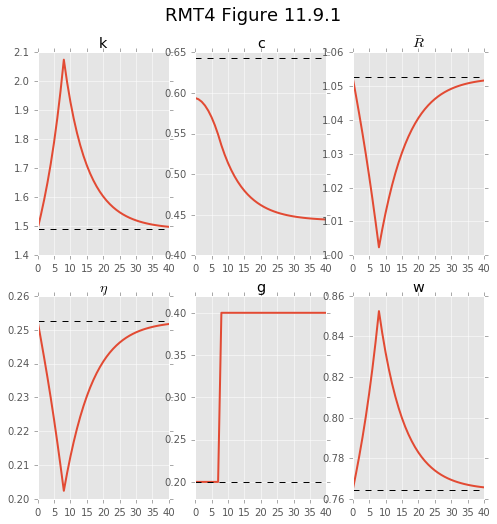

In [87]:
# Generate plots
psol = sol.ix[:p_T]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
for ind_i, i in enumerate(names):
    for ind_k, k in enumerate(i):
        ax_ik = axes[ind_i, ind_k]
        psol[k].plot(ax=ax_ik, linewidth=2, title=titles[ind_i][ind_k])
        ax_ik.plot(o * ss[ind_i][ind_k], 'k--')
axes[1,1].set_ybound(.18, .42)
fig.suptitle('RMT4 Figure 11.9.1', fontsize=18)

Constructing that plot was a lot of book-keeping work.

Thankfully there is a convenient function in dolo that will do most of that work for us, while still allowing us to customize and tweak the figure to our liking. Here's another way we might have created the figure above.

In [88]:
plot_kwargs = dict(variables=['k','c','R','eta','g', 'w'],
                   line_options=[
                       {'color':'black', 'linestyle':'--'},
                       {'linewidth':2},
                       {'linewidth':2, "linestyle": "-."},
                   ],
                   titles=['k', 'c', r'$\bar{R}$', r'$\eta$', 'g', 'w'])

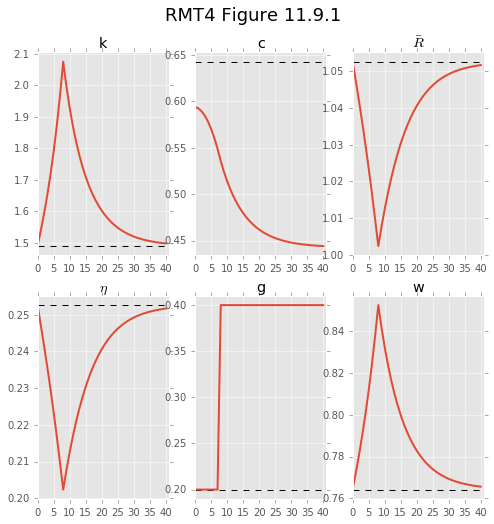

In [89]:
# one can add some options to make it look exactly like the former graph
fig = plot_irfs([sol_ref, psol], **plot_kwargs)
fig.suptitle('RMT4 Figure 11.9.1', fontsize=18)

## RMT4 Figure 11.9.2

In [62]:
# Change gamma and compute solution again
model.set_calibration('gamma', 0.2)
sol2 = pf.deterministic_solve(model, shocks=shocks_1, T=T, ignore_constraints=True)
psol2 = sol2.ix[:p_T]

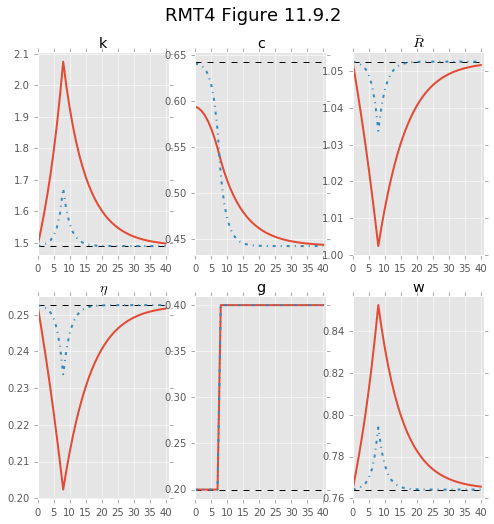

In [71]:
# generate figure
fig = plot_irfs([sol_ref, psol, psol2], **plot_kwargs)
fig.suptitle('RMT4 Figure 11.9.2', fontsize=18)

## RMT4 Figure 11.9.3

In [10]:
model.set_calibration('gamma', 2.0)
beta, gamma = model.get_calibration('beta'), 2.0
n = np.arange(1, sol.shape[0] + 1)

# Compute q and qbar
q = beta ** n  * sol['c'] ** (-gamma)  / (beta ** 2 * sol['c'][1] ** (-gamma))
qbar = beta ** (n - 1)
sol['q'] = q
sol['qbar'] = qbar

# Compute r and rbar
sol['r'] = sol['R'] - 1
rbar = sol['R'][0] - 1

# comupte r_{t, s+t}
rst = np.zeros((40, 62))
for t in range(62):
    for i in range(40):
        rst[i, t] = np.log(q[i+t]/  q[t]) / (-i)      

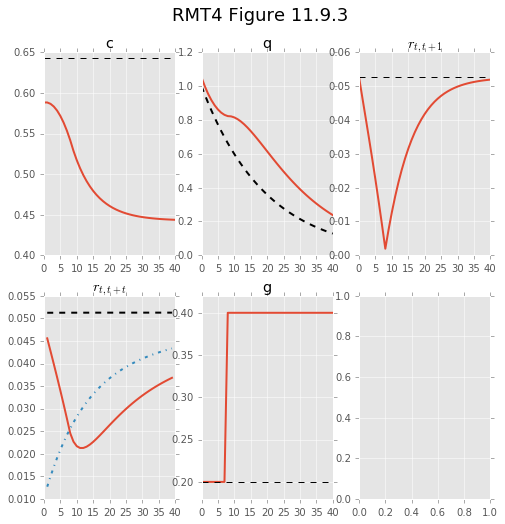

In [11]:
fig3, axes3 = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
psol3 = sol.ix[:p_T]
psol3['c'].plot(ax=axes3[0,0], linewidth=2, title='c'); axes3[0,0].plot(o * cbar, 'k--')
psol3[['q', 'qbar']].plot(ax=axes3[0,1], linewidth=2, title='q', legend=None, style=['-', 'k--'])
psol3['r'].plot(ax=axes3[0,2], linewidth=2, title=r'$r_{t, t+1}$'); axes3[0,2].plot(o * rbar, 'k--')
axes3[1,0].plot(range(p_T), rst[:, 1], range(p_T), rst[:, 10], '-.', range(p_T), rst[:, -1], 'k--', linewidth=2)
axes3[1, 0].set_title(r'$r_{t, t+t}$')
psol3['g'].plot(ax=axes3[1,1], linewidth=2, title='g'); axes3[1,1].plot(o * g[0], 'k--'); axes3[1,1].set_ybound(.18, .42)
fig3.suptitle('RMT4 Figure 11.9.3', fontsize=18)